<h1>RFM analysis and Clustering using e-commerce data</h1>

<h2>Introduction</h2>

A company may have tones of transactional data but it's hard for them using those data data to segmentize their customers,
RFM (Recency, Frequency, Monetary) is a typical measure to analyze the customer value.

In below project, RFM analysis and K-Means clustering will be used to segmentize customers in an e-commerce transactional data
<br>The e-commerce data is the open data from <a href ="http://archive.ics.uci.edu/ml/index.php">The UCI Machine Learning Repository</a>

<h2>Data Preparation</h2>

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import squarify

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
#Import csv file
txn = pd.read_csv('data.csv', encoding= 'unicode_escape')

In [3]:
#Convert InvoiceDate to Date data type
txn['InvoiceDate'] = pd.to_datetime(txn['InvoiceDate']).dt.date

In [4]:
print(txn.info())
print(txn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01       2.55     

In [5]:
#Check number of records in the dataset
print('There are {} records in the dataset.'.format(len(txn)))

There are 541909 records in the dataset.


<h2>Data Manipulation</h2>

<p>Since we are having RFM analysis to customers only, transactions without customer ID will be removed from the dataset</p>

In [6]:
#Remove transactions with no Customer ID mapped
txn_cleanse = txn[~txn['CustomerID'].isna()]

In [7]:
#Check number of records in the dataset
print('There are {} records in the dataset.'.format(len(txn_cleanse)))

There are 406829 records in the dataset.


In the data exploration, there are duplicated records which maybe due to system issue or human error.
They will be removed to ensure data quality.

In [8]:
#Check number of duplicated records in the dataset
print('There are {} duplicated records in the dataset.'.format(txn_cleanse.duplicated().sum()))

There are 5226 duplicated records in the dataset.


In [9]:
#Remove duplicated records
txn_cleanse.drop_duplicates(inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
#Check number of records in the dataset
print('There are {} records in the dataset.'.format(len(txn_cleanse)))

There are 401603 records in the dataset.


Add a Total Price field for later use

In [11]:
#Create a TotalPrice column for later use
txn_cleanse['TotalPrice'] = txn_cleanse['UnitPrice']*txn_cleanse['Quantity']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<h2> Exploratory Data Analysis (EDA)</h2>

<h4>Explore in country level</h4>

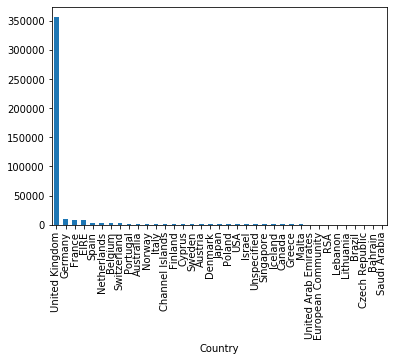

In [12]:
txn_cleanse.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False).plot(kind='bar')
plt.show()

Over 350,000 / 401,604 (87%) of orders were made from UK

Let's take a deeper look to top 5 countries with more metrics

In [13]:
#Group by Country and calculate aggregated metrics
countryagg = txn_cleanse.groupby('Country', as_index = False).agg({'InvoiceNo':'nunique', 'TotalPrice':'sum', 'Quantity':'sum', 'CustomerID':'nunique'})
countryagg.columns = ['Country','TotalTxn','TotalSpend','TotalQty','TotalCustomer']
countryagg['AvgCustomerSpend'] = countryagg['TotalSpend']/countryagg['TotalCustomer']
countryagg['AvgTransaction'] = countryagg['TotalTxn']/countryagg['TotalCustomer']
countryagg['AvgTicketSize'] = countryagg['TotalSpend']/countryagg['TotalTxn']

#Show the top 5 countries
print(countryagg.sort_values('TotalTxn', ascending = False).nlargest(5, 'TotalTxn'))

           Country  TotalTxn    TotalSpend  TotalQty  TotalCustomer  \
35  United Kingdom     19857  6.747152e+06   3994868           3950   
14         Germany       603  2.215095e+05    117341             95   
13          France       458  1.966260e+05    109806             87   
10            EIRE       319  2.500018e+05    136187              3   
3          Belgium       119  4.091096e+04     23152             25   

    AvgCustomerSpend  AvgTransaction  AvgTicketSize  
35       1708.139811        5.027089     339.787090  
14       2331.678632        6.347368     367.345721  
13       2260.069540        5.264368     429.314520  
10      83333.926667      106.333333     783.704639  
3        1636.438400        4.760000     343.789580  


Although UK had the largest proportion of transactions, they made only around 1700 spend per customer which was slightly less than other countries.
For EIRE, 7,475 of transactions were made by 3 customers and these three customers were probably wholesalers.

<h4>Explore in customer level</h4>

In [14]:
#Check number of customers in the dataset
print('There are {} customers in the dataset.'.format(txn_cleanse['CustomerID'].nunique()))

There are 4372 customers in the dataset.


To facilitate the customer analysis afterward, transaction data will be grouped into customer level

In [15]:
#Group by Customer and calculate aggregated metrics
cust = txn_cleanse.groupby('CustomerID', as_index = False).agg({'InvoiceNo':'count', 'TotalPrice':'sum', 'Quantity':'sum'})
cust.columns = ['CustomerID','TotalTxn','TotalSpend','TotalQty']
cust['AvgTicketSize'] = cust['TotalSpend']/cust['TotalTxn']
print(cust.head())

   CustomerID  TotalTxn  TotalSpend  TotalQty  AvgTicketSize
0     12346.0         2        0.00         0       0.000000
1     12347.0       182     4310.00      2458      23.681319
2     12348.0        31     1797.24      2341      57.975484
3     12349.0        73     1757.55       631      24.076027
4     12350.0        17      334.40       197      19.670588


Since there are cancelled orders in the transactions, total spend of a customer may equal or less than zero

In [16]:
#Check number of customers with total spend <= 0
cust[cust['TotalSpend'] <= 0].count()

CustomerID       50
TotalTxn         50
TotalSpend       50
TotalQty         50
AvgTicketSize    50
dtype: int64

Since the number of customers having zero or negative spend are only 50, those customers are removed in the dataset

In [17]:
cust = cust[cust['TotalSpend'] > 0]

#Check number of customers in the dataset
print('There are {} customers in the dataset.'.format(cust['CustomerID'].nunique()))

There are 4322 customers in the dataset.


In [18]:
#Assign Country to each customer
#Since a customer may have transactions made from different countries, assign the country with most number of transactions
cust_country_count = txn_cleanse.groupby(['CustomerID', 'Country'], as_index = False)['InvoiceNo'].count()
cust_country = cust_country_count.groupby('CustomerID')['Country', 'InvoiceNo'].apply(lambda x: x.nlargest(1,'InvoiceNo')).reset_index()

cust = cust.merge(cust_country[['CustomerID','Country']])

          TotalSpend     TotalTxn  AvgTicketSize
count    4322.000000  4322.000000    4322.000000
mean     1918.006710    92.848218      30.784822
std      8262.493177   230.356873     104.927766
min         0.000000     1.000000       0.000000
25%       300.000000    18.000000      11.000000
50%       653.000000    42.000000      17.000000
75%      1624.000000   101.000000      23.000000
max    279489.000000  7812.000000    3861.000000


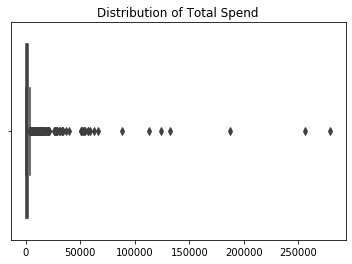

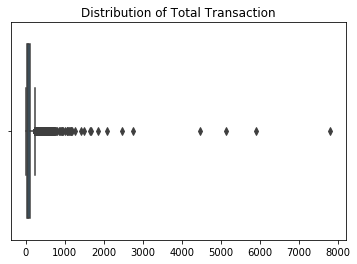

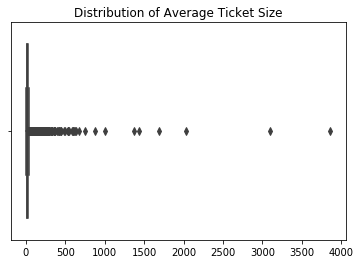

In [19]:
#Find the distribution of the Total Spend, Total Txn, Average ticket size of customers
print(cust[['TotalSpend','TotalTxn','AvgTicketSize']].astype('int').describe())

sns.boxplot(x = ['TotalSpend'], data = cust)
plt.title('Distribution of Total Spend')
plt.show()
sns.boxplot(x = ['TotalTxn'], data = cust)
plt.title('Distribution of Total Transaction')
plt.show()
sns.boxplot(x = ['AvgTicketSize'], data = cust)
plt.title('Distribution of Average Ticket Size')
plt.show()

Since there are several outliers having extra high total spend or total transactions which may affect the afterward analysis, remove the outliers with total spend more than \\$3500 or total transactions more than 200

In [20]:
cust[cust['TotalSpend'] > 3500].count()

cust = cust[(cust['TotalSpend'] <= 3500) & (cust['TotalTxn'] <= 200)]

In [21]:
#Check number of customers in the dataset
print('There are {} customers in the dataset.'.format(cust['CustomerID'].nunique()))

There are 3702 customers in the dataset.


        TotalSpend     TotalTxn  AvgTicketSize
count  3702.000000  3702.000000    3702.000000
mean    791.373582    48.815775      27.247434
std     738.934600    44.342671      77.811801
min       0.000000     1.000000       0.000000
25%     258.000000    15.000000      12.000000
50%     530.500000    33.000000      16.000000
75%    1071.750000    70.000000      22.000000
max    3497.000000   200.000000    3096.000000


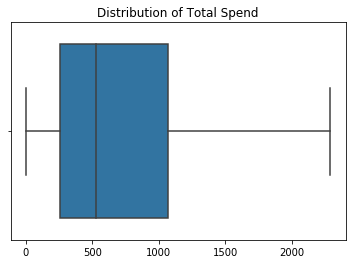

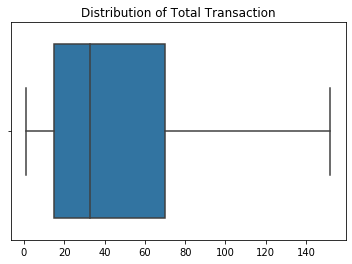

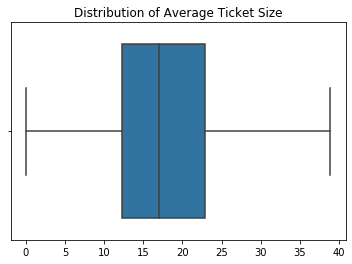

In [22]:
#Find the distribution of the Total Spend, Total Txn, Average ticket size of customers
print(cust[['TotalSpend','TotalTxn','AvgTicketSize']].astype('int').describe())

sns.boxplot(x = ['TotalSpend'], data = cust, showfliers = False)
plt.title('Distribution of Total Spend')
plt.show()
sns.boxplot(x = ['TotalTxn'], data = cust, showfliers = False)
plt.title('Distribution of Total Transaction')
plt.show()
sns.boxplot(x = ['AvgTicketSize'], data = cust, showfliers = False)
plt.title('Distribution of Average Ticket Size')
plt.show()

The total spend were mainly ranging from \\$258 to \\$1072 and median spend was on \\$531.
<br>The total transactions were mainly ranging from 15 to 70 and median transactions was on 33.
<br>The average ticket size were mainly ranging from \\$12 to \\$22 and median spend was on \\$16.

<h2> RFM Analysis</h2>

RFM is a method used for analyzing customer value and is commonly used in database marketing and direct marketing.

In the RFM analysis below, RFM will be defined as follows:

R = Recency - How recently the customer spent in the shop?<br>
F = Frequency - How many transactions did the customers make?<br>
M = Monetary - How much money did the customers spend?

In [23]:
#Assign RFM to each customer

#Calculate and assign Recency of each customer
max_invoice_date = txn_cleanse['InvoiceDate'].max()
print('The latest invoice date in the dataset is {}'.format(max_invoice_date))

cust_max_invoice_date = txn_cleanse.groupby('CustomerID', as_index = False)['InvoiceDate'].max()
cust_max_invoice_date['Recency'] = (max_invoice_date - cust_max_invoice_date['InvoiceDate']).dt.days
cust = cust.merge(cust_max_invoice_date[['CustomerID','Recency']])

#Assign Frequency and Monetary
cust['Frequency'] = cust['TotalTxn']
cust['Monetary'] = cust['TotalSpend']

print(cust.head())

The latest invoice date in the dataset is 2011-12-09
   CustomerID  TotalTxn  TotalSpend  TotalQty  AvgTicketSize  Country  \
0     12348.0        31     1797.24      2341      57.975484  Finland   
1     12349.0        73     1757.55       631      24.076027    Italy   
2     12350.0        17      334.40       197      19.670588   Norway   
3     12352.0        95     1545.41       470      16.267474   Norway   
4     12353.0         4       89.00        20      22.250000  Bahrain   

   Recency  Frequency  Monetary  
0       75         31   1797.24  
1       18         73   1757.55  
2      310         17    334.40  
3       36         95   1545.41  
4      204          4     89.00  


Scoring will be performed to each dimension with score from 1 to 5

<br>The score will be determined by each 20 percentile
<br>Higher frequency and monetary will have higher score while lower recency will have higher score

After that, a RFM score will be determined by combining the score of all RFM dimensions and a total score by summarizing the scores

In [24]:
cust['RScore'] = pd.qcut(cust['Recency'], 5, labels = [5, 4, 3, 2, 1]).astype('int')
cust['FScore'] = pd.qcut(cust['Frequency'], 5, labels = [1, 2, 3, 4, 5]).astype('int')
cust['MScore'] = pd.qcut(cust['Monetary'], 5, labels = [1, 2, 3, 4, 5]).astype('int')

cust['RFMScore'] = cust['RScore'].astype('str') + cust['FScore'].astype('str') + cust['MScore'].astype('str')
cust['TotalScore'] = cust['RScore'] + cust['FScore'] + cust['MScore']

print(cust.head())

   CustomerID  TotalTxn  TotalSpend  TotalQty  AvgTicketSize  Country  \
0     12348.0        31     1797.24      2341      57.975484  Finland   
1     12349.0        73     1757.55       631      24.076027    Italy   
2     12350.0        17      334.40       197      19.670588   Norway   
3     12352.0        95     1545.41       470      16.267474   Norway   
4     12353.0         4       89.00        20      22.250000  Bahrain   

   Recency  Frequency  Monetary  RScore  FScore  MScore RFMScore  TotalScore  
0       75         31   1797.24       3       3       5      335          11  
1       18         73   1757.55       4       4       5      445          13  
2      310         17    334.40       1       2       2      122           5  
3       36         95   1545.41       4       5       5      455          14  
4      204          4     89.00       1       1       1      111           3  


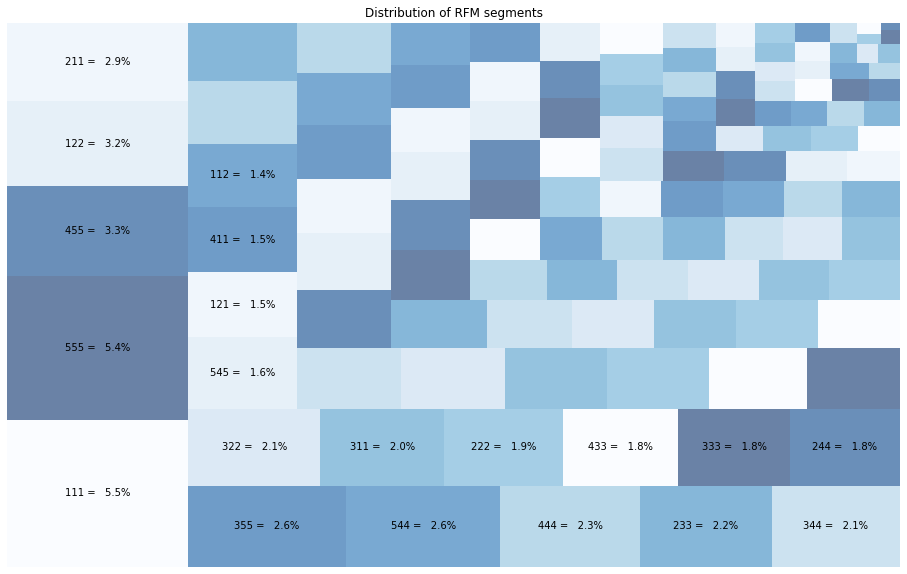

In [25]:
#Group the RFM segments
rfm_count = cust.groupby('RFMScore', as_index = False).agg({'CustomerID':'count','TotalScore':'max'}).sort_values('CustomerID', ascending = False)

#Create a color palette and mapped to the total score
cmap = matplotlib.cm.Blues
mini=min(rfm_count['TotalScore'])
maxi=max(rfm_count['TotalScore'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in rfm_count['TotalScore'].unique()]

#Create percentage of each segment
perc = [f'{i/rfm_count["CustomerID"].sum()*100:5.1f}%' for i in rfm_count['CustomerID']]
lbl = [f'{el[0]} = {el[1]}' for el in zip(rfm_count['RFMScore'], perc)]

#Resize Tree map
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)

squarify.plot(sizes = rfm_count['CustomerID'], label = lbl[:20], color=colors , alpha=0.6 )
plt.axis('off')
plt.title('Distribution of RFM segments')
plt.show()

5.4% of customers are segmented as 555 which are the top customers in the customer base while we cannot lost them
<br>At the same time, 5.5% of customers are segmented as 111 which are the least valued customers

<h2>K-Means Clustering</h2>

Apart from clustering by RFM score, K-Means clustering can be performed using the RFM score to understanding the grouping of the customers
<br>Since k-means clustering is highly affected by the scale of the attributes, the attributes need to be normalized

In [26]:
#Normalize the RFM value
scaler = MinMaxScaler()
cust_rfm_normalize = pd.DataFrame(scaler.fit_transform(cust[['Recency','Frequency','Monetary']]))
print(cust_rfm_normalize)

             0         1         2
0     0.201072  0.150754  0.513917
1     0.048257  0.361809  0.502568
2     0.831099  0.080402  0.095621
3     0.096515  0.472362  0.441907
4     0.546917  0.015075  0.025449
...        ...       ...       ...
3697  0.195710  0.040201  0.049726
3698  0.742627  0.045226  0.051642
3699  0.482574  0.030151  0.023110
3700  0.018767  0.060302  0.050498
3701  0.112601  0.346734  0.525366

[3702 rows x 3 columns]


In [27]:
cust_rfm_normalize.describe()

,0,1,2
count,3702.000000,3702.000000,3702.000000
mean,0.270707,0.240280,0.226431
std,0.273129,0.222827,0.211298
min,0.000000,0.000000,0.000000
25%,0.058981,0.070352,0.074015
50%,0.158177,0.160804,0.151771
75%,0.439678,0.346734,0.306607
max,1.000000,1.000000,1.000000


In order to design the least number of clusters to be clustered with the smallest distortion, elbow method will be used

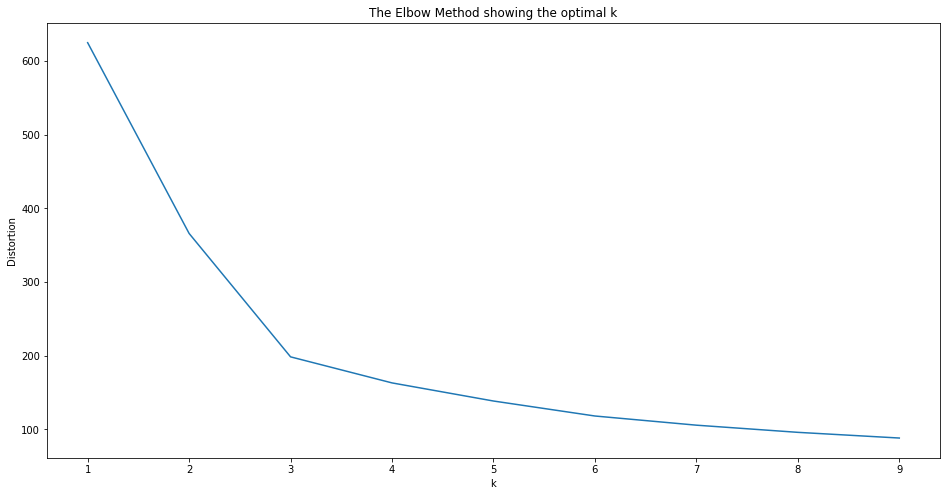

In [28]:
#Create an empty list for storing distortion with different number of k
distortion = []

#Generate distortion for each k
for k in range(1,10):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(cust_rfm_normalize)
    distortion.append(kmeans.inertia_)
    
#Plot the elbow method
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortion)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe 3 is the optimal k so it will be used to run the K-Means Clustering

In [29]:
#Run the K-Means Clustering with k=3
kmeans = KMeans(n_clusters = 3, random_state = 1234)
kmeans.fit(cust_rfm_normalize)
cust['Segment'] = kmeans.predict(cust_rfm_normalize)

We can now visualize the clusters in RFM dimensions

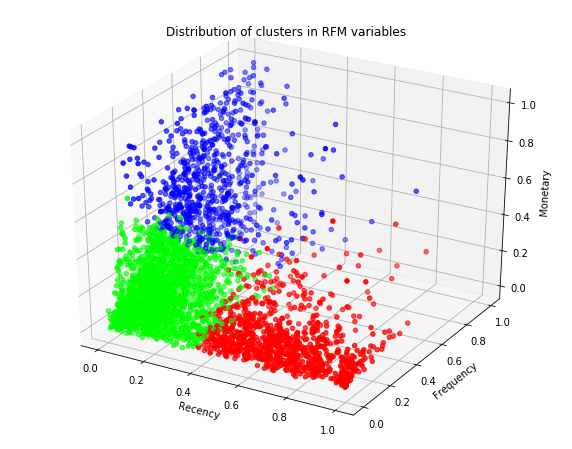

In [30]:
#Plot the scatter plot in 3D diagram
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cust_rfm_normalize[0], cust_rfm_normalize[1], cust_rfm_normalize[2], cmap = 'brg', c = cust['Segment'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('Distribution of clusters in RFM variables')
plt.show()

In [31]:
#Summarize the RFM variables for each segment
cust.groupby('Segment').agg({'Recency':['mean','min','max'],'Frequency':['mean','min','max'],'Monetary':['mean','min','max','count']})

Recency             Frequency              Monetary                \
               mean  min  max        mean min  max         mean           min   
Segment                                                                         
0         40.173691    0  315  116.487867   1  200  1863.551036  4.050400e+02   
1        251.843685  143  373   23.048654   1  155   365.281170  4.263256e-14   
2         50.726062    0  169   34.429595   1  115   573.196699  1.243450e-14   

                        
             max count  
Segment                 
0        3497.14   783  
1        2661.24   966  
2        2560.00  1953

In summary, segment 0 (21% of customers) is a group of top customers which have relatively lower value of recency but higher value of frequency and monetary while segment 1 (26% of customers) is group of lowest value customers

<h2>Conclusion</h2>

After setting RFM score and segments of customer, marketing team can make use of these measures to have better planning of their marketing resources on campaigns. Since RFM analysis solely using the transactional data to analyze, SKU data and customer demographic data can be considered to add for enriching the segmentation